In [4]:
import os
import glob
import pandas as pd

# 6score 的根目錄
root_dir = "/home/t113ab8043/Desktop/nanten_railway_code/資料集/已處理資料/6score"

# 轉換 中文類別 → 整數 label
label_map = {
    "正常": 0,
    "異常": 1,
    "故障": 2,
}

rows = []

# 走過每一個 turnout 資料夾：P1602N, P1602R, ...
for device_name in os.listdir(root_dir):
    device_path = os.path.join(root_dir, device_name)
    if not os.path.isdir(device_path):
        continue

    # 走過三個子資料夾：正常 / 異常 / 故障
    for class_name in ["正常", "異常", "故障"]:
        class_folder = os.path.join(device_path, class_name)
        if not os.path.isdir(class_folder):
            continue

        csv_paths = glob.glob(os.path.join(class_folder, "*.csv"))
        for path in csv_paths:
            rows.append({
                "file_path": path,
                "device": device_name,     # P1602N / P1602R / ...
                "class_name": class_name,  # 正常 / 異常 / 故障
                "label_idx": label_map[class_name],
            })

manifest = pd.DataFrame(rows)
print("總樣本數：", len(manifest))
display(manifest.head())

print("\n整體類別分布：")
print(manifest["class_name"].value_counts())


總樣本數： 4372


,file_path,device,class_name,label_idx
0,/home/t113ab8043/Desktop/nanten_railway_code/資...,P1602N,正常,0
1,/home/t113ab8043/Desktop/nanten_railway_code/資...,P1602N,正常,0
2,/home/t113ab8043/Desktop/nanten_railway_code/資...,P1602N,正常,0
3,/home/t113ab8043/Desktop/nanten_railway_code/資...,P1602N,正常,0
4,/home/t113ab8043/Desktop/nanten_railway_code/資...,P1602N,正常,0



整體類別分布：
class_name
正常    3222
異常    1028
故障     122
Name: count, dtype: int64


In [5]:
from sklearn.model_selection import train_test_split

# 先做 manifest（跟之前一樣）
# manifest 需要有 device 和 class_name 兩欄

# 新增一個「分層 key」：設備 + 類別
manifest["strata"] = manifest["device"] + "_" + manifest["class_name"]

print("不同 (device, class) 組合數：", manifest["strata"].nunique())
print(manifest["strata"].value_counts())

# 1) 先切出 train (75%) 和 temp (25%)
train_df, temp_df = train_test_split(
    manifest,
    test_size=0.25,
    stratify=manifest["strata"],   # ← 用 strata 分層
    random_state=42,
)

# 2) 再把 temp 切成 val/test
# 想要：val = 10%, test = 15%  → 在 temp(25%) 裡：val: 0.4, test: 0.6
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.6,
    stratify=temp_df["strata"],    # ← 一樣用 strata 分層
    random_state=42,
)

# # 1) 第一刀：切出 Test (0.2) 和 Train_Val (0.8)
# train_val_df, test_df = train_test_split(
#     manifest,
#     test_size=0.2,               # 總體的 20% 給 Test
#     stratify=manifest["strata"], # 根據 strata 分層
#     random_state=42,
# )

# # 2) 第二刀：從 Train_Val (0.8) 中切出 Val (總體的 0.1)
# # 計算比例：想要 0.1 / 目前手上的 0.8 = 0.125
# train_df, val_df = train_test_split(
#     train_val_df,
#     test_size=0.125,             # 0.125 * 0.8 = 0.1 (總體)
#     stratify=train_val_df["strata"],
#     random_state=42,
# )

print("Train size:", len(train_df))
print("Val size:  ", len(val_df))
print("Test size: ", len(test_df))
print("Total:     ", len(manifest))

print("\nTrain 類別分布：")
print(train_df["class_name"].value_counts())
print("\nVal 類別分布：")
print(val_df["class_name"].value_counts())
print("\nTest 類別分布：")
print(test_df["class_name"].value_counts())

print("\nTrain 設備分布：")
print(train_df["device"].value_counts())
print("\nVal 設備分布：")
print(val_df["device"].value_counts())
print("\nTest 設備分布：")
print(test_df["device"].value_counts())


不同 (device, class) 組合數： 16
strata
P1604R_正常    838
P1604N_正常    838
P1603N_正常    526
P1603R_正常    496
P1602N_正常    364
P1603R_異常    324
P1603N_異常    308
P1602R_異常    294
P1602R_正常    160
P1602N_異常    102
P1603N_故障     38
P1603R_故障     28
P1602R_故障     19
P1604N_故障     17
P1602N_故障     12
P1604R_故障      8
Name: count, dtype: int64
Train size: 3279
Val size:   437
Test size:  656
Total:      4372

Train 類別分布：
class_name
正常    2416
異常     772
故障      91
Name: count, dtype: int64

Val 類別分布：
class_name
正常    322
異常    102
故障     13
Name: count, dtype: int64

Test 類別分布：
class_name
正常    484
異常    154
故障     18
Name: count, dtype: int64

Train 設備分布：
device
P1603N    653
P1604N    641
P1603R    636
P1604R    635
P1602N    359
P1602R    355
Name: count, dtype: int64

Val 設備分布：
device
P1603N    88
P1604N    86
P1603R    85
P1604R    84
P1602N    47
P1602R    47
Name: count, dtype: int64

Test 設備分布：
device
P1603N    131
P1604N    128
P1604R    127
P1603R    127
P1602N     72
P1602R     71
Name: c

In [3]:
import pandas as pd

# 把三個資料集放在一起，方便迴圈處理
datasets = {
    "Train": train_df,
    "Val": val_df,
    "Test": test_df
}

for name, df in datasets.items():
    print(f"\n{'='*20} {name} Set Distribution (Device vs Class) {'='*20}")
    
    # 使用 crosstab 建立交叉表：Rows=設備, Columns=類別
    # margins=True 會幫你算出總和 (All)
    dist_table = pd.crosstab(
        index=df['device'], 
        columns=df['class_name'], 
        margins=True, 
        margins_name="Total"
    )
    
    print(dist_table)
    
    # 檢查是否有任何數值為 0 (不含 Total 欄列)
    # 我們只檢查核心數據區域
    core_data = dist_table.iloc[:-1, :-1] 
    if (core_data == 0).any().any():
        print(f"⚠️ 警告：在 {name} 集中，有部分「設備+類別」的數量為 0！")
    else:
        print(f"✅ 檢查通過：{name} 集中，每個設備的每個類別都有資料。")


==================== Train Set Distribution (Device vs Class) ====================
class_name  故障    正常   異常  Total
device                          
P1602N       9   273   77    359
P1602R      14   120  221    355
P1603N      28   394  231    653
P1603R      21   372  243    636
P1604N      13   628    0    641
P1604R       6   629    0    635
Total       91  2416  772   3279
⚠️ 警告：在 Train 集中，有部分「設備+類別」的數量為 0！

==================== Val Set Distribution (Device vs Class) ====================
class_name  故障   正常   異常  Total
device                         
P1602N       1   36   10     47
P1602R       2   16   29     47
P1603N       4   53   31     88
P1603R       3   50   32     85
P1604N       2   84    0     86
P1604R       1   83    0     84
Total       13  322  102    437
⚠️ 警告：在 Val 集中，有部分「設備+類別」的數量為 0！

==================== Test Set Distribution (Device vs Class) ====================
class_name  故障   正常   異常  Total
device                         
P1602N       2   55   15     72
P1

In [ ]:
# =============================================================================
#  前置準備 (Prerequisites) - for 四公式版本
# =============================================================================
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# 這裡假設：
# - train_df / val_df / test_df 已經從 manifest 切好
# - 欄位裡有：file_path, label_idx

# --- 連續特徵：保留 NCurrent & RCurrent，不合併，外加 WRVT ---
CONT_COLS = ["NCurrent", "RCurrent", "WRVT"]

# --- 類別/旗標特徵：保留你原來那組 ---
BIN_CAT_COLS = ["NLR", "SRWKR", "SNWKR", "RWKR", "NWKR", "RLR", "FOCR", "NWR", "RWR"]

BATCH_SIZE = 20

# 1. 收集所有訓練 csv 裡的連續特徵
cont_data_list = []
for path in train_df["file_path"]:
    df = pd.read_csv(path)

    # 確保欄位存在，沒有就補 0
    for col in CONT_COLS:
        if col not in df.columns:
            df[col] = 0.0

    cont_data_list.append(df[CONT_COLS])

all_train_cont_data = pd.concat(cont_data_list, ignore_index=True)

# 2. fit scaler
scaler = StandardScaler()
scaler.fit(all_train_cont_data)

print("StandardScaler 已在訓練集連續特徵上擬合完畢！")

# =============================================================================
#  PyTorch Dataset 類別（四公式版）
# =============================================================================
class EventDataset(Dataset):
    def __init__(self, manifest_df, cont_cols, bin_cat_cols, scaler):
        """
        manifest_df: 需包含
        - file_path: csv 完整路徑
        - label_idx: 0/1/2 (四公式分類結果)
        """
        self.manifest = manifest_df.reset_index(drop=True)
        self.cont_cols = cont_cols
        self.bin_cat_cols = bin_cat_cols
        self.scaler = scaler

    def __len__(self):
        return len(self.manifest)

    def __getitem__(self, idx):
        row = self.manifest.iloc[idx]
        path = row["file_path"]
        label = int(row["label_idx"])

        try:
            df = pd.read_csv(path)

            # --- 確保所有特徵欄位存在，缺的補 0 ---
            for c in self.cont_cols + self.bin_cat_cols:
                if c not in df.columns:
                    df[c] = 0.0

            # --- 對連續特徵做標準化 ---
            if self.scaler is not None and not df[self.cont_cols].empty:
                df[self.cont_cols] = self.scaler.transform(df[self.cont_cols])

            feats = []

            # 連續特徵：每一欄變成 (T,1) tensor，之後 cat 起來
            for c in self.cont_cols:
                vals = df[c].values.astype(np.float32)
                feats.append(torch.from_numpy(vals).unsqueeze(1))  # (T,1)

            # 旗標特徵：0/1，缺失補 0
            for c in self.bin_cat_cols:
                vals = (
                    df[c]
                    .fillna(0)
                    .astype(int)
                    .clip(0, 1)
                    .values
                    .astype(np.float32)
                )
                feats.append(torch.from_numpy(vals).unsqueeze(1))  # (T,1)

            if not feats:
                # 理論上不會發生，防呆一下
                return {
                    "features": torch.empty(0, 0),
                    "length": 0,
                    "label": torch.tensor(-1, dtype=torch.long),
                }

            # (T, feature_dim) = cat((T,1), ..., dim=1)
            features_tensor = torch.cat(feats, dim=1)

            return {
                "features": features_tensor,                # (T, 12)
                "length": features_tensor.shape[0],         # T
                "label": torch.tensor(label, dtype=torch.long),  # 0/1/2
            }

        except Exception as e:
            print(f"\n在處理檔案 {path} 時發生錯誤：{e}")
            raise e

# =============================================================================
#  collate_fn：padding，lengths 之後可給 pack_padded_sequence 用
# =============================================================================
def collate_fn(batch):
    # 過濾掉長度為 0 的樣本（防呆）
    batch = [item for item in batch if item["length"] > 0]
    if not batch:
        return {
            "features": torch.empty(0, 0, 0),
            "lengths": torch.empty(0),
            "labels": torch.empty(0),
        }

    features_list = [item["features"] for item in batch]  # list of (T_i, 12)
    lengths_list = [item["length"] for item in batch]     # list of T_i
    labels_list = [item["label"] for item in batch]       # list of scalar

    # padding 成 (batch, T_max, feature_dim)
    padded_features = pad_sequence(
        features_list,
        batch_first=True,
        padding_value=0.0,
    )

    return {
        "features": padded_features,                               # (B, T_max, 12)
        "lengths": torch.tensor(lengths_list, dtype=torch.long),   # (B,)
        "labels": torch.stack(labels_list),                        # (B,)
    }

# =============================================================================
#  建立 Dataset 和 DataLoader
# =============================================================================
print("\n" + "="*50)
print("       正在建立 Dataset 和 DataLoader...")
print("="*50)

train_dataset = EventDataset(train_df, CONT_COLS, BIN_CAT_COLS, scaler)
val_dataset   = EventDataset(val_df,   CONT_COLS, BIN_CAT_COLS, scaler)
test_dataset  = EventDataset(test_df,  CONT_COLS, BIN_CAT_COLS, scaler)

from torch.utils.data import WeightedRandomSampler
import numpy as np
import torch

# =========================
# WeightedRandomSampler（溫和版）
# 目標：讓故障(2)在 batch 中出現率提升到約 5–10%
# =========================

labels = train_df["label_idx"].astype(int).values
class_counts = np.bincount(labels)
print("Train class counts:", class_counts)  # e.g. [n0, n1, n2]

alpha = 0.4  # 溫和起手（你要小幅提升就用 0.5；想更強就 0.6~0.7）

# 反頻率權重（溫和版）
class_w = np.zeros_like(class_counts, dtype=np.float64)
for c in range(len(class_counts)):
    if class_counts[c] > 0:
        class_w[c] = 1.0 / (class_counts[c] ** alpha)
    else:
        class_w[c] = 0.0

# 不一定要 normalize，但我建議印出來看比較直觀
class_w = class_w / class_w.sum()
print("Class weights for sampling:", class_w)

sample_weights = class_w[labels]  # 每筆樣本對應到它類別的權重
sample_weights = torch.tensor(sample_weights, dtype=torch.double)

train_sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=train_sampler,   # ✅ 用 sampler
    shuffle=False,           # ✅ sampler 與 shuffle 不能同時開
    collate_fn=collate_fn,
)

# train_loader = DataLoader(
#     train_dataset,
#     batch_size=BATCH_SIZE,
#     shuffle=True,
#     collate_fn=collate_fn,
# )
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
)

print("DataLoader 建立完成！")

# =============================================================================
#  驗證 DataLoader 的輸出
# =============================================================================
print("\n" + "="*50)
print("              驗證 DataLoader 輸出")
print("="*50)

try:
    first_batch = next(iter(train_loader))
    padded_features = first_batch["features"]
    lengths = first_batch["lengths"]
    labels = first_batch["labels"]

    print("成功從 train_loader 取出一個批次！")
    print(f"\nFeatures 形狀: {padded_features.shape}")  # (B, T_max, 12)
    print(f"Lengths 形狀:  {lengths.shape}")
    print(f"Labels 形狀:   {labels.shape}")
    print("\n前 10 筆資料的真實長度:", lengths[:10].tolist())
    print("\n資料已準備就緒，可以與 pack_padded_sequence 配合餵入 LSTM 模型！")

except StopIteration:
    print("錯誤：訓練資料集為空，無法從 train_loader 中取出資料。")
except Exception as e:
    print(f"\n在嘗試從 DataLoader 取出第一個批次時發生錯誤：{e}")

print("="*50)


StandardScaler 已在訓練集連續特徵上擬合完畢！

       正在建立 Dataset 和 DataLoader...
Train class counts: [2416  772   91]
Class weights for sampling: [0.15897164 0.25090627 0.59012209]
DataLoader 建立完成！

              驗證 DataLoader 輸出
成功從 train_loader 取出一個批次！

Features 形狀: torch.Size([20, 877, 12])
Lengths 形狀:  torch.Size([20])
Labels 形狀:   torch.Size([20])

前 10 筆資料的真實長度: [293, 276, 290, 280, 304, 283, 301, 289, 276, 273]

資料已準備就緒，可以與 pack_padded_sequence 配合餵入 LSTM 模型！


In [8]:
from collections import Counter

def check_sampled_distribution(loader, num_batches=50):
    counts = Counter()
    total = 0
    for i, batch in enumerate(loader):
        if i >= num_batches:
            break
        y = batch["labels"].cpu().numpy().tolist()
        counts.update(y)
        total += len(y)

    dist = {k: v/total for k, v in sorted(counts.items())}
    print(f"[Sampled {total} samples from {num_batches} batches]")
    print("counts:", dict(counts))
    print("distribution:", dist)
    print(f"fault(class=2) ratio ≈ {dist.get(2,0)*100:.2f}%")

check_sampled_distribution(train_loader, num_batches=50)


[Sampled 1000 samples from 50 batches]
counts: {0: 625, 2: 80, 1: 295}
distribution: {0: 0.625, 1: 0.295, 2: 0.08}
fault(class=2) ratio ≈ 8.00%


In [9]:
print("開始顯示所有 batch：\n")

for batch_idx, batch in enumerate(train_loader):
    features = batch['features']
    lengths = batch['lengths']
    labels  = batch['labels']

    print(f"--- Batch {batch_idx+1} ---")
    print(f"features.shape = {features.shape}")   # [batch_size, max_len, feature_dim]
    print(f"lengths       = {lengths.tolist()}") # 每條序列真實長度
    print(f"labels        = {labels.tolist()}")  # class labels
    print()

print("\n📌 Done! 已顯示所有 batch。")


開始顯示所有 batch：

--- Batch 1 ---
features.shape = torch.Size([20, 945, 12])
lengths       = [289, 290, 301, 279, 281, 291, 308, 801, 303, 310, 288, 282, 289, 286, 275, 289, 945, 284, 291, 296]
labels        = [0, 0, 1, 1, 0, 1, 0, 2, 1, 1, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0]

--- Batch 2 ---
features.shape = torch.Size([20, 945, 12])
lengths       = [299, 314, 290, 899, 304, 306, 291, 291, 310, 287, 290, 945, 302, 290, 293, 313, 283, 263, 302, 277]
labels        = [0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 1, 1, 0, 0, 1, 0]

--- Batch 3 ---
features.shape = torch.Size([20, 902, 12])
lengths       = [277, 293, 8, 292, 306, 266, 298, 284, 285, 293, 887, 902, 278, 289, 292, 298, 286, 294, 294, 293]
labels        = [0, 1, 2, 0, 1, 1, 0, 0, 1, 0, 2, 2, 0, 0, 0, 2, 0, 1, 1, 1]

--- Batch 4 ---
features.shape = torch.Size([20, 945, 12])
lengths       = [858, 305, 301, 297, 298, 304, 295, 290, 285, 299, 316, 275, 296, 296, 294, 287, 945, 293, 297, 295]
labels        = [2, 0, 0, 0, 2, 0, 0, 0, 0, 1, 1,

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm  # 用於顯示進度條
import numpy as np
import copy  # 用來保存最佳模型參數

# =======================
#     訓練設定
# =======================

# 透過檢查第一個批次來自動獲取特徵數量，讓程式碼更具彈性
try:
    temp_batch = next(iter(train_loader))
    INPUT_SIZE = temp_batch['features'].shape[2]
except (StopIteration, IndexError):
    print("無法從 DataLoader 自動獲取 INPUT_SIZE，請手動設定。")
    # ✅ 這裡不再用 ZONES，因為我們已經拿掉 Zone one-hot
    INPUT_SIZE = len(CONT_COLS) + len(BIN_CAT_COLS)

HIDDEN_SIZE = 128      # LSTM 隱藏層大小
NUM_LAYERS = 2         # LSTM 堆疊層數

# ✅ 類別數量直接從四公式 label_idx 推出
NUM_CLASSES = train_df["label_idx"].nunique()
LEARNING_RATE = 0.0005
NUM_EPOCHS = 100       # 訓練回合數
DROPOUT = 0.3          # Dropout 比例，防止過擬合

# --- 環境設定 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"將使用設備: {device}")
print(f"自動偵測到的特徵數量 (Input Size): {INPUT_SIZE}")
print(f"類別數量 (NUM_CLASSES): {NUM_CLASSES}")


# =======================
#     LSTM 分類器定義
# =======================

# --- LSTM 分類器定義 ---
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,  # 我們的輸入是 (batch, seq, feature)
            dropout=dropout if num_layers > 1 else 0.0  # 單層 LSTM 不啟用 dropout
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x, lengths):
        # x: [batch_size, max_seq_len, input_size]
        # lengths: [batch_size]，每條序列真實長度（未 pad 的長度）

        # 1. pack_padded_sequence：讓 LSTM 忽略 padding 的 0
        packed_input = nn.utils.rnn.pack_padded_sequence(
            x, lengths.cpu(), batch_first=True, enforce_sorted=False
        )

        # 2. 丟進 LSTM
        # output 無需使用，只需要最後一層的 hidden state
        _, (h_n, _) = self.lstm(packed_input)

        # 3. 取最後一層的 hidden state
        # h_n: [num_layers, batch_size, hidden_size]
        last_hidden_state = h_n[-1]  # [batch_size, hidden_size]

        # 4. Dropout + 全連接分類
        out = self.dropout(last_hidden_state)
        out = self.fc(out)  # [batch_size, num_classes]
        return out

# --- 實例化模型 ---
model = LSTMClassifier(
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    num_classes=NUM_CLASSES,
    dropout=DROPOUT
).to(device)


# =======================
#   類別權重（處理不平衡）
# =======================

# ✅ 用四公式產生的 label_idx 當作類別
class_counts = train_df['label_idx'].value_counts().sort_index()

# N / (K * n_k)
weights = len(train_df) / (len(class_counts) * class_counts)
class_weights = torch.tensor(weights.values, dtype=torch.float32).to(device)
class_weights = torch.sqrt(class_weights)

print("\n計算出的類別權重 (用於損失函數):")
for cls_idx, w in enumerate(class_weights):
    print(f"  類別 {cls_idx}: 權重 = {w:.3f}")
print()

# --- 損失函數與優化器 ---
# criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# [新增] 學習率排程器 (對應圖片中的 scheduler.step)
# 當 val_loss 沒進步時，自動降低學習率
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True, threshold=1e-3
)

# 印一下模型結構確認
print(model)


# =======================
#     訓練 & 評估函式
# =======================

def train_one_epoch(model, loader, criterion, optimizer, device, clip_max_norm=1.0):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    grad_norms = []
    clipped_count = 0
    batch_count = 0
    
    for batch in tqdm(loader, desc="訓練中 (Training)"):
        features = batch['features'].to(device)   # [batch, max_seq_len, input_size]
        lengths = batch['lengths']               # [batch]
        labels = batch['labels'].to(device)      # [batch]

        optimizer.zero_grad()

        # forward
        outputs = model(features, lengths)       # [batch, num_classes]
        loss = criterion(outputs, labels)

        # backward
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_max_norm)
        gn = float(grad_norm.detach().cpu().item())
        grad_norms.append(gn)
        batch_count += 1
        if gn > clip_max_norm:
            clipped_count += 1
        # print(grad_norm)
        
        optimizer.step()

        # 統計 loss / acc
        running_loss += loss.item() * features.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    epoch_loss = running_loss / total_samples if total_samples > 0 else 0.0
    epoch_acc = correct_predictions / total_samples if total_samples > 0 else 0.0
    
    if batch_count > 0:
        print(
            f"[GradNorm Stats] max={np.max(grad_norms):.3f}, "
            f"mean={np.mean(grad_norms):.3f}, "
            f"clip%={(clipped_count/batch_count)*100:.1f}% "
            f"({clipped_count}/{batch_count})"
        )
    
    return epoch_loss, epoch_acc


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for batch in tqdm(loader, desc="評估中 (Evaluating)"):
            features = batch['features'].to(device)
            lengths = batch['lengths']
            labels = batch['labels'].to(device)

            outputs = model(features, lengths)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * features.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    epoch_loss = running_loss / total_samples if total_samples > 0 else 0.0
    epoch_acc = correct_predictions / total_samples if total_samples > 0 else 0.0
    return epoch_loss, epoch_acc, np.array(all_labels), np.array(all_predictions)


# =======================
#       主訓練迴圈
#   + 儲存 & 載入最佳模型
# =======================

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}


# --- Early Stopping 設定 (參考圖片) ---
patience_es = 10         # 容忍次數：建議 8~12
min_delta = 1e-3         # 門檻：val_loss 至少要下降超過這個值才算有進步
no_improve = 0           # 計數器：目前已經幾次沒進步了

best_val_loss = float("inf")   # 我們要找最小的 loss
best_state_dict = None
best_epoch = -1
best_val_acc_at_best_loss = None  # 記錄當時的 val_acc 方便查看

print(f"\n 開始訓練 (設定: Patience={patience_es}, Min Delta={min_delta})")


for epoch in range(NUM_EPOCHS):
    print(f"\n=== Epoch {epoch+1}/{NUM_EPOCHS} ===")

    # 1. 訓練一個 epoch
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, device
    )

    # 2. 在驗證集上做評估
    val_loss, val_acc, val_labels, val_preds = evaluate(
        model, val_loader, criterion, device
    )
    
    # 3. 紀錄 history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # 4. 印出當前 epoch 結果
    print(f"Epoch {epoch+1} 結果:")
    print(f"  訓練損失 (Train Loss): {train_loss:.4f} | 訓練準確率 (Train Acc): {train_acc:.4f}")
    print(f"  驗證損失 (Val Loss):   {val_loss:.4f} | 驗證準確率 (Val Acc):   {val_acc:.4f}")

    # # 5. 以 Val Loss 判斷最佳模型
    # if val_loss < best_val_loss:
    #     best_val_loss = val_loss
    #     best_epoch = epoch + 1
    #     best_val_acc_at_best_loss = val_acc
    #     best_state_dict = copy.deepcopy(model.state_dict())
    #     print(f"✨ 發現更好的模型！（以 Val Loss 判斷）")
    #     print(f"   目前最佳 Epoch = {best_epoch}, Val Loss = {best_val_loss:.4f}, 對應 Val Acc = {best_val_acc_at_best_loss:.4f}")
    
    # ===============================
    #    Early Stopping 核心邏輯
    # ===============================
    
    # 判斷是否有「顯著」進步 (小於 best - min_delta)
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        best_state_dict = copy.deepcopy(model.state_dict())
        best_epoch = epoch + 1
        best_val_acc_at_best_loss = val_acc
        no_improve = 0  # 重置計數器
        
        print(f" 發現顯著進步的模型！ (Val Loss: {val_loss:.4f}) -> 已儲存")
    else:
        no_improve += 1
        print(f" 未顯著進步 (目前忍受次數: {no_improve}/{patience_es})")

    # 更新 Scheduler (根據 val_loss 調整學習率)
    scheduler.step(val_loss)
    
    # [放在這裡] 印出當前的 Learning Rate
    print(f"Current LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    # 檢查是否觸發 Early Stopping
    if no_improve >= patience_es:
        print(f"\n Early stopping at epoch {epoch+1} (Best epoch was {best_epoch})")
        break

print("\n訓練完成！")

# 6. 載入整個過程中「Val Loss 最低」那個 epoch 的模型
if best_state_dict is not None:
    model.load_state_dict(best_state_dict)
    print(f"✅ 已載入最佳模型（依 Val Loss 最低選擇）")
    print(f"   來自 Epoch {best_epoch}, Val Loss = {best_val_loss:.4f}, 對應 Val Acc = {best_val_acc_at_best_loss:.4f}")
else:
    print("⚠ 未成功紀錄最佳模型，請檢查 val_loader 或訓練流程。")


將使用設備: cuda
自動偵測到的特徵數量 (Input Size): 12
類別數量 (NUM_CLASSES): 3

計算出的類別權重 (用於損失函數):
  類別 0: 權重 = 0.673
  類別 1: 權重 = 1.190
  類別 2: 權重 = 3.466

LSTMClassifier(
  (lstm): LSTM(12, 128, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)

 開始訓練 (設定: Patience=10, Min Delta=0.001)

=== Epoch 1/100 ===


/home/t113ab8043/.conda/envs/switch_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=8.676, mean=1.321, clip%=38.4% (63/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 1 結果:
  訓練損失 (Train Loss): 0.7812 | 訓練準確率 (Train Acc): 0.6407
  驗證損失 (Val Loss):   0.5237 | 驗證準確率 (Val Acc):   0.7689
 發現顯著進步的模型！ (Val Loss: 0.5237) -> 已儲存
Current LR: 0.000500

=== Epoch 2/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=14.250, mean=2.539, clip%=86.0% (141/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 2 結果:
  訓練損失 (Train Loss): 0.6203 | 訓練準確率 (Train Acc): 0.7066
  驗證損失 (Val Loss):   0.5305 | 驗證準確率 (Val Acc):   0.7025
 未顯著進步 (目前忍受次數: 1/10)
Current LR: 0.000500

=== Epoch 3/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=12.102, mean=2.672, clip%=88.4% (145/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 3 結果:
  訓練損失 (Train Loss): 0.6040 | 訓練準確率 (Train Acc): 0.7063
  驗證損失 (Val Loss):   0.5150 | 驗證準確率 (Val Acc):   0.7231
 發現顯著進步的模型！ (Val Loss: 0.5150) -> 已儲存
Current LR: 0.000500

=== Epoch 4/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=43.848, mean=3.080, clip%=88.4% (145/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 4 結果:
  訓練損失 (Train Loss): 0.5707 | 訓練準確率 (Train Acc): 0.7298
  驗證損失 (Val Loss):   0.4890 | 驗證準確率 (Val Acc):   0.7895
 發現顯著進步的模型！ (Val Loss: 0.4890) -> 已儲存
Current LR: 0.000500

=== Epoch 5/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=46.249, mean=3.820, clip%=86.0% (141/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 5 結果:
  訓練損失 (Train Loss): 0.5558 | 訓練準確率 (Train Acc): 0.7155
  驗證損失 (Val Loss):   0.5467 | 驗證準確率 (Val Acc):   0.7071
 未顯著進步 (目前忍受次數: 1/10)
Current LR: 0.000500

=== Epoch 6/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=32.720, mean=4.299, clip%=95.7% (157/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 6 結果:
  訓練損失 (Train Loss): 0.5382 | 訓練準確率 (Train Acc): 0.7396
  驗證損失 (Val Loss):   0.4750 | 驗證準確率 (Val Acc):   0.7666
 發現顯著進步的模型！ (Val Loss: 0.4750) -> 已儲存
Current LR: 0.000500

=== Epoch 7/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=125.617, mean=6.367, clip%=95.1% (156/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 7 結果:
  訓練損失 (Train Loss): 0.5368 | 訓練準確率 (Train Acc): 0.7414
  驗證損失 (Val Loss):   0.4233 | 驗證準確率 (Val Acc):   0.8444
 發現顯著進步的模型！ (Val Loss: 0.4233) -> 已儲存
Current LR: 0.000500

=== Epoch 8/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=115.376, mean=9.581, clip%=94.5% (155/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 8 結果:
  訓練損失 (Train Loss): 0.5006 | 訓練準確率 (Train Acc): 0.7841
  驗證損失 (Val Loss):   0.3782 | 驗證準確率 (Val Acc):   0.8490
 發現顯著進步的模型！ (Val Loss: 0.3782) -> 已儲存
Current LR: 0.000500

=== Epoch 9/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=72.819, mean=7.738, clip%=92.1% (151/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 9 結果:
  訓練損失 (Train Loss): 0.4783 | 訓練準確率 (Train Acc): 0.8033
  驗證損失 (Val Loss):   0.5691 | 驗證準確率 (Val Acc):   0.6499
 未顯著進步 (目前忍受次數: 1/10)
Current LR: 0.000500

=== Epoch 10/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=275.113, mean=9.504, clip%=95.1% (156/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 10 結果:
  訓練損失 (Train Loss): 0.5190 | 訓練準確率 (Train Acc): 0.7768
  驗證損失 (Val Loss):   0.3630 | 驗證準確率 (Val Acc):   0.8604
 發現顯著進步的模型！ (Val Loss: 0.3630) -> 已儲存
Current LR: 0.000500

=== Epoch 11/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=160.371, mean=8.519, clip%=87.2% (143/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 11 結果:
  訓練損失 (Train Loss): 0.4257 | 訓練準確率 (Train Acc): 0.8530
  驗證損失 (Val Loss):   0.3527 | 驗證準確率 (Val Acc):   0.8558
 發現顯著進步的模型！ (Val Loss: 0.3527) -> 已儲存
Current LR: 0.000500

=== Epoch 12/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=474.719, mean=12.482, clip%=92.1% (151/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 12 結果:
  訓練損失 (Train Loss): 0.3928 | 訓練準確率 (Train Acc): 0.8597
  驗證損失 (Val Loss):   0.3379 | 驗證準確率 (Val Acc):   0.8741
 發現顯著進步的模型！ (Val Loss: 0.3379) -> 已儲存
Current LR: 0.000500

=== Epoch 13/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=91.503, mean=11.247, clip%=95.7% (157/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 13 結果:
  訓練損失 (Train Loss): 0.3577 | 訓練準確率 (Train Acc): 0.8625
  驗證損失 (Val Loss):   0.3562 | 驗證準確率 (Val Acc):   0.8581
 未顯著進步 (目前忍受次數: 1/10)
Current LR: 0.000500

=== Epoch 14/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=241.214, mean=12.103, clip%=97.0% (159/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 14 結果:
  訓練損失 (Train Loss): 0.3418 | 訓練準確率 (Train Acc): 0.8750
  驗證損失 (Val Loss):   0.2465 | 驗證準確率 (Val Acc):   0.9016
 發現顯著進步的模型！ (Val Loss: 0.2465) -> 已儲存
Current LR: 0.000500

=== Epoch 15/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=198.191, mean=10.970, clip%=89.6% (147/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 15 結果:
  訓練損失 (Train Loss): 0.3565 | 訓練準確率 (Train Acc): 0.8673
  驗證損失 (Val Loss):   0.4237 | 驗證準確率 (Val Acc):   0.8558
 未顯著進步 (目前忍受次數: 1/10)
Current LR: 0.000500

=== Epoch 16/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=496.435, mean=16.323, clip%=91.5% (150/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 16 結果:
  訓練損失 (Train Loss): 0.3231 | 訓練準確率 (Train Acc): 0.8896
  驗證損失 (Val Loss):   0.3748 | 驗證準確率 (Val Acc):   0.8993
 未顯著進步 (目前忍受次數: 2/10)
Current LR: 0.000500

=== Epoch 17/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=87.513, mean=12.831, clip%=97.0% (159/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 17 結果:
  訓練損失 (Train Loss): 0.2985 | 訓練準確率 (Train Acc): 0.8914
  驗證損失 (Val Loss):   0.2534 | 驗證準確率 (Val Acc):   0.9085
 未顯著進步 (目前忍受次數: 3/10)
Current LR: 0.000500

=== Epoch 18/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=726.195, mean=19.306, clip%=95.1% (156/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 18 結果:
  訓練損失 (Train Loss): 0.2747 | 訓練準確率 (Train Acc): 0.9045
  驗證損失 (Val Loss):   0.1634 | 驗證準確率 (Val Acc):   0.9451
 發現顯著進步的模型！ (Val Loss: 0.1634) -> 已儲存
Current LR: 0.000500

=== Epoch 19/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=370.324, mean=16.772, clip%=92.7% (152/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 19 結果:
  訓練損失 (Train Loss): 0.3158 | 訓練準確率 (Train Acc): 0.8923
  驗證損失 (Val Loss):   0.2215 | 驗證準確率 (Val Acc):   0.9062
 未顯著進步 (目前忍受次數: 1/10)
Current LR: 0.000500

=== Epoch 20/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=222.604, mean=16.474, clip%=92.7% (152/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 20 結果:
  訓練損失 (Train Loss): 0.2764 | 訓練準確率 (Train Acc): 0.8960
  驗證損失 (Val Loss):   0.2113 | 驗證準確率 (Val Acc):   0.9199
 未顯著進步 (目前忍受次數: 2/10)
Current LR: 0.000500

=== Epoch 21/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=87.414, mean=15.581, clip%=97.0% (159/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 21 結果:
  訓練損失 (Train Loss): 0.2461 | 訓練準確率 (Train Acc): 0.9088
  驗證損失 (Val Loss):   0.2798 | 驗證準確率 (Val Acc):   0.8764
 未顯著進步 (目前忍受次數: 3/10)
Current LR: 0.000500

=== Epoch 22/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=134.341, mean=16.923, clip%=94.5% (155/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 22 結果:
  訓練損失 (Train Loss): 0.2612 | 訓練準確率 (Train Acc): 0.9052
  驗證損失 (Val Loss):   0.2022 | 驗證準確率 (Val Acc):   0.9291
 未顯著進步 (目前忍受次數: 4/10)
Current LR: 0.000500

=== Epoch 23/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=100.729, mean=12.658, clip%=95.7% (157/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 23 結果:
  訓練損失 (Train Loss): 0.2490 | 訓練準確率 (Train Acc): 0.9131
  驗證損失 (Val Loss):   0.2970 | 驗證準確率 (Val Acc):   0.9153
 未顯著進步 (目前忍受次數: 5/10)
Current LR: 0.000500

=== Epoch 24/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=96.988, mean=15.503, clip%=97.6% (160/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 24 結果:
  訓練損失 (Train Loss): 0.2712 | 訓練準確率 (Train Acc): 0.9058
  驗證損失 (Val Loss):   0.1940 | 驗證準確率 (Val Acc):   0.9359
 未顯著進步 (目前忍受次數: 6/10)
Current LR: 0.000250

=== Epoch 25/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=92.337, mean=17.101, clip%=92.7% (152/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 25 結果:
  訓練損失 (Train Loss): 0.1913 | 訓練準確率 (Train Acc): 0.9329
  驗證損失 (Val Loss):   0.1451 | 驗證準確率 (Val Acc):   0.9588
 發現顯著進步的模型！ (Val Loss: 0.1451) -> 已儲存
Current LR: 0.000250

=== Epoch 26/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=156.386, mean=15.861, clip%=91.5% (150/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 26 結果:
  訓練損失 (Train Loss): 0.2125 | 訓練準確率 (Train Acc): 0.9308
  驗證損失 (Val Loss):   0.1963 | 驗證準確率 (Val Acc):   0.9405
 未顯著進步 (目前忍受次數: 1/10)
Current LR: 0.000250

=== Epoch 27/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=414.567, mean=23.807, clip%=92.7% (152/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 27 結果:
  訓練損失 (Train Loss): 0.2055 | 訓練準確率 (Train Acc): 0.9329
  驗證損失 (Val Loss):   0.1572 | 驗證準確率 (Val Acc):   0.9474
 未顯著進步 (目前忍受次數: 2/10)
Current LR: 0.000250

=== Epoch 28/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=209.125, mean=19.436, clip%=85.4% (140/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 28 結果:
  訓練損失 (Train Loss): 0.1789 | 訓練準確率 (Train Acc): 0.9445
  驗證損失 (Val Loss):   0.1615 | 驗證準確率 (Val Acc):   0.9497
 未顯著進步 (目前忍受次數: 3/10)
Current LR: 0.000250

=== Epoch 29/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=144.511, mean=20.140, clip%=96.3% (158/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 29 結果:
  訓練損失 (Train Loss): 0.1668 | 訓練準確率 (Train Acc): 0.9457
  驗證損失 (Val Loss):   0.2002 | 驗證準確率 (Val Acc):   0.9336
 未顯著進步 (目前忍受次數: 4/10)
Current LR: 0.000250

=== Epoch 30/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=114.379, mean=16.839, clip%=89.6% (147/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 30 結果:
  訓練損失 (Train Loss): 0.1842 | 訓練準確率 (Train Acc): 0.9451
  驗證損失 (Val Loss):   0.2287 | 驗證準確率 (Val Acc):   0.9314
 未顯著進步 (目前忍受次數: 5/10)
Current LR: 0.000250

=== Epoch 31/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=189.164, mean=18.468, clip%=91.5% (150/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 31 結果:
  訓練損失 (Train Loss): 0.2019 | 訓練準確率 (Train Acc): 0.9372
  驗證損失 (Val Loss):   0.1398 | 驗證準確率 (Val Acc):   0.9588
 發現顯著進步的模型！ (Val Loss: 0.1398) -> 已儲存
Current LR: 0.000250

=== Epoch 32/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=245.791, mean=23.183, clip%=88.4% (145/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 32 結果:
  訓練損失 (Train Loss): 0.1981 | 訓練準確率 (Train Acc): 0.9350
  驗證損失 (Val Loss):   0.1193 | 驗證準確率 (Val Acc):   0.9703
 發現顯著進步的模型！ (Val Loss: 0.1193) -> 已儲存
Current LR: 0.000250

=== Epoch 33/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=158.515, mean=18.009, clip%=86.0% (141/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 33 結果:
  訓練損失 (Train Loss): 0.1658 | 訓練準確率 (Train Acc): 0.9494
  驗證損失 (Val Loss):   0.1595 | 驗證準確率 (Val Acc):   0.9542
 未顯著進步 (目前忍受次數: 1/10)
Current LR: 0.000250

=== Epoch 34/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=347.539, mean=19.478, clip%=86.0% (141/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 34 結果:
  訓練損失 (Train Loss): 0.1641 | 訓練準確率 (Train Acc): 0.9463
  驗證損失 (Val Loss):   0.1352 | 驗證準確率 (Val Acc):   0.9565
 未顯著進步 (目前忍受次數: 2/10)
Current LR: 0.000250

=== Epoch 35/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=159.365, mean=22.632, clip%=90.2% (148/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 35 結果:
  訓練損失 (Train Loss): 0.1895 | 訓練準確率 (Train Acc): 0.9424
  驗證損失 (Val Loss):   0.1933 | 驗證準確率 (Val Acc):   0.9474
 未顯著進步 (目前忍受次數: 3/10)
Current LR: 0.000250

=== Epoch 36/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=267.361, mean=18.771, clip%=86.0% (141/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 36 結果:
  訓練損失 (Train Loss): 0.1755 | 訓練準確率 (Train Acc): 0.9475
  驗證損失 (Val Loss):   0.1670 | 驗證準確率 (Val Acc):   0.9474
 未顯著進步 (目前忍受次數: 4/10)
Current LR: 0.000250

=== Epoch 37/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=327.139, mean=25.173, clip%=86.0% (141/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 37 結果:
  訓練損失 (Train Loss): 0.2002 | 訓練準確率 (Train Acc): 0.9393
  驗證損失 (Val Loss):   0.2361 | 驗證準確率 (Val Acc):   0.9268
 未顯著進步 (目前忍受次數: 5/10)
Current LR: 0.000250

=== Epoch 38/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=113.502, mean=20.440, clip%=86.0% (141/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 38 結果:
  訓練損失 (Train Loss): 0.1732 | 訓練準確率 (Train Acc): 0.9424
  驗證損失 (Val Loss):   0.1748 | 驗證準確率 (Val Acc):   0.9542
 未顯著進步 (目前忍受次數: 6/10)
Current LR: 0.000125

=== Epoch 39/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=136.094, mean=20.300, clip%=92.7% (152/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 39 結果:
  訓練損失 (Train Loss): 0.1814 | 訓練準確率 (Train Acc): 0.9466
  驗證損失 (Val Loss):   0.1346 | 驗證準確率 (Val Acc):   0.9657
 未顯著進步 (目前忍受次數: 7/10)
Current LR: 0.000125

=== Epoch 40/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=209.188, mean=27.704, clip%=86.6% (142/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 40 結果:
  訓練損失 (Train Loss): 0.1389 | 訓練準確率 (Train Acc): 0.9570
  驗證損失 (Val Loss):   0.1281 | 驗證準確率 (Val Acc):   0.9657
 未顯著進步 (目前忍受次數: 8/10)
Current LR: 0.000125

=== Epoch 41/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=158.265, mean=26.771, clip%=81.7% (134/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 41 結果:
  訓練損失 (Train Loss): 0.1407 | 訓練準確率 (Train Acc): 0.9561
  驗證損失 (Val Loss):   0.1377 | 驗證準確率 (Val Acc):   0.9634
 未顯著進步 (目前忍受次數: 9/10)
Current LR: 0.000125

=== Epoch 42/100 ===


訓練中 (Training):   0%|          | 0/164 [00:00<?, ?it/s]

[GradNorm Stats] max=210.911, mean=22.702, clip%=79.9% (131/164)


評估中 (Evaluating):   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 42 結果:
  訓練損失 (Train Loss): 0.1452 | 訓練準確率 (Train Acc): 0.9591
  驗證損失 (Val Loss):   0.1653 | 驗證準確率 (Val Acc):   0.9565
 未顯著進步 (目前忍受次數: 10/10)
Current LR: 0.000125

 Early stopping at epoch 42 (Best epoch was 32)

訓練完成！
✅ 已載入最佳模型（依 Val Loss 最低選擇）
   來自 Epoch 32, Val Loss = 0.1193, 對應 Val Acc = 0.9703


In [14]:
import joblib  # 用來存 Scaler
import os

print("\n訓練完成！")

# 6. 載入整個過程中「Val Loss 最低」那個 epoch 的模型
if best_state_dict is not None:
    # 回填最佳參數
    model.load_state_dict(best_state_dict)
    print(f"✅ 已載入最佳模型（依 Val Loss 最低選擇）")
    print(f"   來自 Epoch {best_epoch}, Val Loss = {best_val_loss:.4f}, 對應 Val Acc = {best_val_acc_at_best_loss:.4f}")
    
    # 1. 設定你想要的新資料夾名稱
    output_folder = "/home/t113ab8043/Desktop/nanten_railway_code/2_ML/loadingmodel/test"  # <--- 你可以隨意改這個名字
    
    # ==========================================
    # [關鍵修改] 同時儲存模型參數與 Scaler
    # ==========================================
    
    os.makedirs(output_folder, exist_ok=True)
    print(f"📂 目標資料夾已準備就緒: {output_folder}")
    
    # --- 儲存模型參數 ---
    # os.path.join 會自動幫你處理路徑斜線問題 (e.g. folder/file.pth)
    model_save_path = os.path.join(output_folder, 'best_lstm_model_test.pth')
    torch.save(model.state_dict(), model_save_path)
    print(f"💾 模型參數已儲存: {model_save_path}")
    
    # --- 儲存 StandardScaler ---
    scaler_save_path = os.path.join(output_folder, 'scaler.pkl')
    joblib.dump(scaler, scaler_save_path)
    print(f"💾 Scaler 已儲存: {scaler_save_path}")
    
    # --- 儲存 History ---
    history_save_path = os.path.join(output_folder, 'history.pkl')
    joblib.dump(history, history_save_path)
    print(f"📉 訓練紀錄已儲存: {history_save_path}")
else:
    print("⚠ 未成功紀錄最佳模型，請檢查 val_loader 或訓練流程。")


訓練完成！
✅ 已載入最佳模型（依 Val Loss 最低選擇）
   來自 Epoch 32, Val Loss = 0.1193, 對應 Val Acc = 0.9703
📂 目標資料夾已準備就緒: /home/t113ab8043/Desktop/nanten_railway_code/2_ML/loadingmodel/test
💾 模型參數已儲存: /home/t113ab8043/Desktop/nanten_railway_code/2_ML/loadingmodel/test/best_lstm_model_test.pth
💾 Scaler 已儲存: /home/t113ab8043/Desktop/nanten_railway_code/2_ML/loadingmodel/test/scaler.pkl
📉 訓練紀錄已儲存: /home/t113ab8043/Desktop/nanten_railway_code/2_ML/loadingmodel/test/history.pkl


評估中 (Evaluating):   0%|          | 0/33 [00:00<?, ?it/s]


===== Test set 結果 =====
Test Loss: 0.0963
Test Acc : 0.9634

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       484
           1       0.91      0.94      0.92       154
           2       0.81      0.94      0.87        18

    accuracy                           0.96       656
   macro avg       0.90      0.95      0.93       656
weighted avg       0.96      0.96      0.96       656



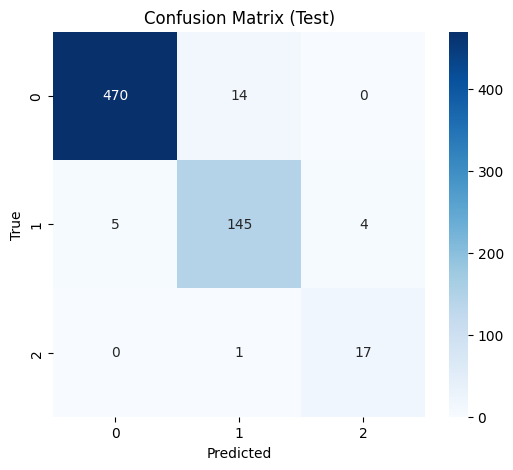

In [15]:
# =======================
#       Test 評估
# =======================
test_loss, test_acc, test_labels, test_preds = evaluate(
    model, test_loader, criterion, device
)

print("\n===== Test set 結果 =====")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Acc : {test_acc:.4f}")

# 分類報告
print("\nClassification Report:")
print(classification_report(test_labels, test_preds))

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


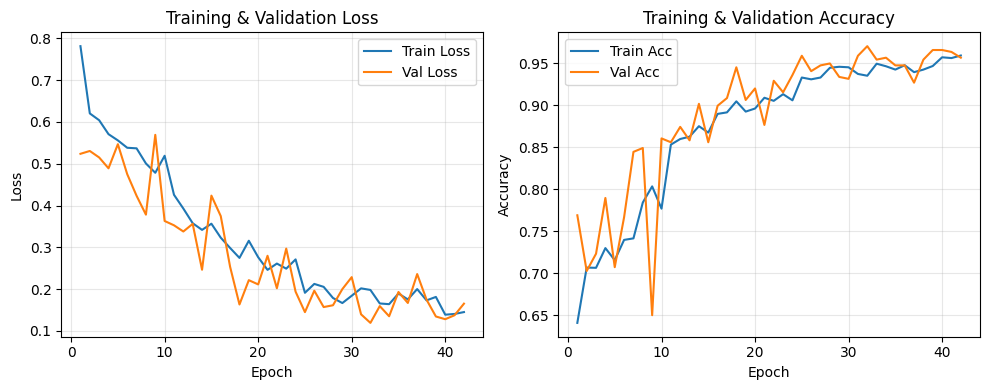

In [16]:
# =======================
#   畫 Loss Curve & Accuracy Curve
# =======================

epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(10, 4))

# ---- Loss curve ----
plt.subplot(1, 2, 1)
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"],   label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(alpha=0.3)

# ---- Accuracy curve ----
plt.subplot(1, 2, 2)
plt.plot(epochs, history["train_acc"], label="Train Acc")
plt.plot(epochs, history["val_acc"],   label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()
